<a href="https://colab.research.google.com/github/sanjaynagi/AnoPrimer/blob/main/notebooks/AnoPrimer-long.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First, install some packages we require
! pip install AgamPrimer -q 

     |████████████████████████████████| 397 kB 5.0 MB/s 
     |████████████████████████████████| 101 kB 4.3 MB/s 
     |████████████████████████████████| 2.2 MB 3.1 MB/s 
     |████████████████████████████████| 79.9 MB 1.3 MB/s 
     |████████████████████████████████| 128 kB 48.4 MB/s 
     |████████████████████████████████| 25.2 MB 1.6 MB/s 
     |████████████████████████████████| 1.6 MB 29.0 MB/s 
     |████████████████████████████████| 3.6 MB 38.7 MB/s 
     |████████████████████████████████| 7.2 MB 22.6 MB/s 
     |████████████████████████████████| 3.7 MB 28.7 MB/s 
     |████████████████████████████████| 191 kB 18.2 MB/s 
     |████████████████████████████████| 3.1 MB 35.0 MB/s 
     |████████████████████████████████| 9.9 MB 53.3 MB/s 
     |████████████████████████████████| 308 kB 25.3 MB/s 
     |████████████████████████████████| 55 kB 2.8 MB/s 
     |████████████████████████████████| 6.7 MB 29.2 MB/s 


In [2]:
# Import libraries 
import AgamPrimer
import malariagen_data
import primer3
import pandas as pd
import numpy as np

##**[AnoPrimer](https://github.com/sanjaynagi/AnoPrimer): Primer design considering genomic variation in *Anopheles gambiae* s.l and *Anopheles funestus***   
**Author**: [Sanjay Curtis Nagi](https://sanjaynagi.github.io/)    
**Email**: sanjay.nagi@lstmed.ac.uk  

Welcome to the AnoPrimer notebook. This is the long version of the notebook which designs primers in steps. Alternatively, there is a all-in-one function in a [short version of the notebook](https://colab.research.google.com/github/sanjaynagi/AnoPrimer/blob/main/notebooks/AnoPrimer-short.ipynb).

We would like to design primers for PCR applications, such as genotyping or gene expression (qPCR). However, single nucleotide polymorphisms (SNPs) in primer binding sites can result in differences or failures in PCR amplification, referred to as null alleles. 

In general, mismatches caused by SNPs are more of a problem as you move towards the 3' end. I recommend reading a really good article on this topic on the IDT website - [Consider SNPs when designing PCR and qPCR assays](https://eu.idtdna.com/pages/education/decoded/article/considering-snps-when-designing-pcr-and-qpcr-assays). In *An. gambiae s.l*, there is a [huge amount of genetic variation](https://genome.cshlp.org/content/30/10/1533.full); a SNP found approximately every 1.9 bases (!), which makes considering SNPs even more important when designing molecular assays. Thanks to primer3-py and the fantastic malariagen_data package, we can do all of this in the cloud, hosted by google!



####**Google Colab**

If you are unfamiliar with iPython notebooks and google colab, I encourage you to read the [FAQ](https://research.google.com/colaboratory/faq.html) and watch the following [introduction](https://www.youtube.com/watch?v=inN8seMm7UI). In general, the cells contain python code, and can be run by pressing the play button next to each cell, and should be run in order.

You may want to save a copy of the notebook into your google drive (`file -> save a copy in Drive`).

In [21]:
#@title **Selecting Primer Parameters** { run: "auto" }
#@markdown In the below cells, replace the values with those desired for your primers and ensure to press the play button (top left) to run the cell.

species = 'gambiae_sl' #@param ["gambiae_sl", "funestus"]
assay_type = 'cDNA primers'           #@param ["gDNA primers", "gDNA primers + probe", "probe", "cDNA primers"]
assay_name = 'coeae2f'        #@param {type:"string"}
min_amplicon_size = 60        #@param {type:"integer"}
max_amplicon_size = 120      #@param {type:"integer"}
amplicon_size_range = [[min_amplicon_size, max_amplicon_size]]
n_primer_pairs = 6            #@param {type:"slider", min:1, max:20, step:1}
cDNA_exon_junction=True #ignore

#@markdown    
#@markdown primer_target should be a region string ('2L:28545767') for gDNA primers and probes, and an AGAP transcript identifier for cDNA primers.

primer_target = 'AGAP006228-RA'      #@param {type:"string"} 

Load sequence data for chromosomal arm of choice, using the [malariagen_data API](https://malariagen.github.io/vector-data/ag3/api.html):

In [4]:
# Connect to the malariagen_data ag3 API
ag3 = malariagen_data.Ag3(url='gs://vo_agam_release/')
contig, target = AgamPrimer.check_and_split_target(target=primer_target, assay_type=assay_type)
genome_seq = ag3.genome_sequence(region=contig)
print(f"Our genome sequence for {contig} is {genome_seq.shape[0]} bp long")

Our genome sequence for 2L is 49364325 bp long


Now we need to extract the bit of sequence we need. We will use functions in the [AgamPrimer](https://pypi.org/project/AgamPrimer/) package.

In [5]:
target_sequence, gdna_pos, seq_parameters = AgamPrimer.prepare_sequence(
                                                                target=target,
                                                                assay_type=assay_type,
                                                                assay_name=assay_name,
                                                                genome_seq=genome_seq,
                                                                amplicon_size_range=amplicon_size_range,
                                                                cDNA_exon_junction=cDNA_exon_junction,
                                                                )

Exon junctions for AGAP006228-RA: [ 330  467 1009] [28548763, 28549199, 28549818] 



Now we have our target sequence. Lets take a look...

In [6]:
target_sequence

'CCGCGGCCTACTGCACAACCACAACTCACGAACCACTTGTCATCTAGAAATCTTCCAACAGAGGTGGTTCAGTTTACTTCTTGCACGGTTCGGGTTGTGATTGTATCAGAGCAGTTGGTGCTGTGTTGTGTCCCTTTTTTGTTCGTCTGATATTTTAGAGCTTTGAAAATTCAAATCATATCAAGCTGCAATGGCCAACAGCGAGCTGATTGTTAGCACCGGCTACGGACCGGTTCAGGGCACAGCCAGGACATCGCTCTACGGGACTGGGTACGTCAGCTTCCAGGGCATCCCGTACGCGAAACCTCCGGTCGGAGAGCTACGTTTTAAGGATCCCACGCCACCTGAAAACTGGACGCAGGTTCTCGATTGTACCGAGCAATGTGACCCTTGCTTTCATTTTGATCGGCGCGTTAACAAAATTGTCGGGAGTGAGGACAGCCTGAGGCTGAACATATTCAGCAAAACGATTAAACCCACCAAACCTCTGCCCGTCATGGTGTACATCTACGGCGGTGGATTCGTCGAAGGTACCAGCGGAACCGAACTGTACGGTCCGGACTATCTGATCGAAAAAGACATCGTGCTGGTAACGCTTAACTATCGCGTCGGAGCACTCGGTTTCCTCTGCTGCCAATCACCCACGGCAGGTGTCCCAGGCAATGCGGGCCTGAAAGACCAAAGGCTGGCGCTCCGATGGGTGCGGGACAACATTGCGTCCTTCGGAGGCGATCCCAGCGCGATCACCCTGTTTGGACACAGCGCCGGGGGAGCGTCGGTACAGTATCACACGATTGCGGACGCGTCGAAGAATTTGTTCCAGCGTGCCATCATCATGTCCGGCAGCACGATGTGCAGCTGGGCCCTTACACCCCAGCGCAACTGGCCGGAAAAACTGGCCAAAGCCATCGGTTGGCAGGGCGAGGGTGATGAGGAGGCGGCGCTGCAATATTTGCGCCAAGCTTCGCCGGAAAGCATTGTGGATCATCAGGAGAAATT

We need to set up some python dictionaries containing our sequence and primer parameters, this will be our input to primer3. In the below cell, you can modify or add primer3 parameters, such as optimal TM, GC content etc etc. A full list of possible parameters and their functions can be found in the [primer3 manual](https://primer3.org/manual.html).

In [7]:
primer_parameters  =  {
        'PRIMER_OPT_SIZE': 20,
        'PRIMER_TASK':'generic',
        'PRIMER_MIN_SIZE': 17,
        'PRIMER_MAX_SIZE': 24,
        'PRIMER_OPT_TM': 60.0,
        'PRIMER_MIN_TM': 57.0,
        'PRIMER_MAX_TM': 63.0,
        'PRIMER_MIN_GC': 35.0,
        'PRIMER_MAX_GC': 75.0,
        'PRIMER_MIN_THREE_PRIME_DISTANCE':3,          # this parameter is the minimum distance between successive pairs. If 1, it means successive primer pairs could be identical bar one base shift
        'PRIMER_INTERNAL_OPT_SIZE': 16,               # Probe size preferences if selected, otherwise ignored
        'PRIMER_INTERNAL_MIN_SIZE': 10,
        'PRIMER_INTERNAL_MAX_SIZE': 22,
        'PRIMER_INTERNAL_MIN_TM': 45,
        'PRIMER_INTERNAL_MAX_TM': 65,                # Probe considerations are quite relaxed, assumed that LNAs will be used later to affect TM
        # Extra primer3 parameters can go here
        # In the same format as above                       
    }

primer_parameters = AgamPrimer.primer_params(primer_parameters=primer_parameters, assay_type=assay_type, n_primer_pairs=n_primer_pairs, amplicon_size_range=amplicon_size_range) ## adds some parameters depending on assay type

#### **Run the primer3 algorithm!**

In [8]:
primer_dict = primer3.designPrimers(seq_args=seq_parameters, global_args=primer_parameters)

It should be *fast*. The output, which we call 'primer_dict', is a python dictionary containing the full results from primer3. We will turn this into a pandas dataframe (i.e a useful, pretty table), containing just the necessary bits of information. First, we'll print some information from the primer3 run.

In [9]:
AgamPrimer.primer3_run_statistics(primer_dict, assay_type)

primer_forward_explain  :  considered 14424, GC content failed 784, low tm 3444, high tm 4772, high hairpin stability 61, long poly-x seq 14, ok 5349 

primer_reverse_explain  :  considered 14414, GC content failed 1032, low tm 3339, high tm 4729, long poly-x seq 18, ok 5296 

primer_pair_explain  :  considered 470962, unacceptable product size 5786, no overlap of required point 465164, primer in pair overlaps a primer in a better pair 7687, ok 12 

primer_forward_num_returned  :  6 

primer_reverse_num_returned  :  6 

primer_probe_num_returned  :  0 

primer_pair_num_returned  :  6 



Now lets wrangle this into an easy to look at table.

In [10]:
primer_df = AgamPrimer.primer3_to_pandas(primer_dict=primer_dict, assay_type=assay_type)
primer_df

primer_pair,0,1,2,3,4,5
parameter,,,,,,
primer_forward_sequence,GACATCGCTCTACGGGACTG,CGTTTTAAGGATCCCACGCC,CTGGGTACGTCAGCTTCCAG,CTTCGCCGGAAAGCATTGTG,GCCGGAAAGCATTGTGGATC,TTTTAAGGATCCCACGCCACC
primer_reverse_sequence,GGTGGCGTGGGATCCTTAAA,GGGTCACATTGCTCGGTACA,GGCGTGGGATCCTTAAAACG,CTTGTATTTCCTGCGGTCCG,GCCTTCTTGTATTTCCTGCGG,ACGCGCCGATCAAAATGAAA
primer_forward_tm,59.970433,59.26916,60.108615,60.454957,59.898781,60.61485
primer_reverse_tm,60.034863,60.036765,59.26916,58.993168,59.598095,59.480481
primer_forward_gc_percent,60.0,55.0,60.0,55.0,55.0,52.380952
primer_reverse_gc_percent,55.0,55.0,55.0,55.0,52.380952,45.0
primer_forward,"(249, 20)","(322, 20)","(266, 20)","(962, 20)","(966, 20)","(324, 21)"
primer_reverse,"(344, 20)","(389, 20)","(341, 20)","(1021, 20)","(1026, 21)","(413, 20)"
primer_pair_product_size,96,68,76,60,61,90



We can write this to .tsv and excel files, which can be explored in other editors. To download a file from colab to your local computer, click the folder panel on the left-hand sidebar, the three dots next your primers.tsv/.xlsx file, and download.

In [11]:
primer_df.to_csv(f"{assay_name}.{assay_type}.tsv", sep="\t")
primer_df.to_excel(f"{assay_name}.{assay_type}.xlsx")

##**Looking for variation using the ag1000g resource and malariagen API**

In Ag3, samples are organised into sample sets. We can load any sample set from the Ag3 resource, but there are quite a few! Lets look at what each sample set contains, breaking it down by species, year and country. 

In [12]:
metadata = ag3.sample_metadata()

Load sample metadata:   0%|          | 0/28 [00:00<?, ?it/s]

In [13]:
pivot_country_year_taxon = (
    metadata
    .pivot_table(
        index=["sample_set", "year", "country"], 
        columns=["taxon"], 
        values="sample_id",
        aggfunc="count",
        fill_value=0
    )
)

pivot_country_year_taxon

taxon                                                arabiensis  coluzzii  \
sample_set   year  country                                                  
AG1000G-AO    2009 Angola                                     0        81   
AG1000G-BF-A  2012 Burkina Faso                               0        82   
AG1000G-BF-B  2014 Burkina Faso                               3        53   
AG1000G-BF-C  2004 Burkina Faso                               0         0   
AG1000G-CD    2015 Democratic Republic of the Congo           0         0   
AG1000G-CF    1993 Central African Republic                   0         5   
              1994 Central African Republic                   0        13   
AG1000G-CI    2012 Cote d'Ivoire                              0        80   
AG1000G-CM-A  2009 Cameroon                                   0         0   
AG1000G-CM-B  2005 Cameroon                                   0         7   
AG1000G-CM-C  2013 Cameroon                                   2        19   
AG1000G-FR    2011 Mayotte                                    0         0   
AG1000G-GA-A  2000 Gabon                                      0         0   
AG1000G-GH    2012 Ghana                                      0        64   
AG1000G-GM-A  2011 Gambia, The                                0         0   
AG1000G-GM-B  2012 Gambia, The                                0         2   
AG1000G-GM-C  2012 Gambia, The                                0        12   
AG1000G-GN-A  2012 Guinea                                     0         4   
AG1000G-GN-B  2012 Guinea                                     0         7   
                   Mali                                       0        28   
AG1000G-GQ    2002 Equatorial Guinea                          0         0   
AG1000G-GW    2010 Guinea-Bissau                              0         0   
AG1000G-KE    2000 Kenya                                      0         0   
              2007 Kenya                                      3         0   
              2012 Kenya                                     10         0   
AG1000G-ML-A  2014 Mali                                       0        27   
AG1000G-ML-B  2004 Mali                                       2        36   
AG1000G-MW    2015 Malawi                                    41         0   
AG1000G-MZ    2003 Mozambique                                 0         0   
              2004 Mozambique                                 0         0   
AG1000G-TZ    2012 Tanzania                                  87         0   
              2013 Tanzania                                   1         0   
              2015 Tanzania                                 137         0   
AG1000G-UG    2012 Uganda                                    82         0   
AG1000G-X    -1    Lab Cross                                  0        74   

taxon                                                gambiae  gcx1  gcx2  \
sample_set   year  country                                                 
AG1000G-AO    2009 Angola                                  0     0     0   
AG1000G-BF-A  2012 Burkina Faso                           98     0     0   
AG1000G-BF-B  2014 Burkina Faso                           46     0     0   
AG1000G-BF-C  2004 Burkina Faso                           13     0     0   
AG1000G-CD    2015 Democratic Republic of the Congo       76     0     0   
AG1000G-CF    1993 Central African Republic                2     0     0   
              1994 Central African Republic               53     0     0   
AG1000G-CI    2012 Cote d'Ivoire                           0     0     0   
AG1000G-CM-A  2009 Cameroon                              303     0     0   
AG1000G-CM-B  2005 Cameroon                               90     0     0   
AG1000G-CM-C  2013 Cameroon                               23     0     0   
AG1000G-FR    2011 Mayotte                                23     0     0   
AG1000G-GA-A  2000 Gabon                                  69     0     0   
AG1000G-GH

Here, we can see the breakdown by sample set for country, species and year. For the purposes of this notebook, let's use the Ghana sample set. If we wanted to use all sample sets, we could supply '3.0' instead of a sample set, which will load all samples from the ag3.0 release.

In [14]:
sample_sets = 'AG1000G-GH'          # sample_set = '3.0' .you can also supply lists with multiple sample sets e.g ['AG1000G-GH', 'AG1000G-CI', 'AG1000G-BF-A']
sample_query = "taxon == 'coluzzii'"                # here we can subset to specific values in the metadata e.g :     "taxon == 'gambiae'" , or "taxon == 'arabiensis'"          

### **Plot allele frequencies in primers locations**

Now we can plot the primers pairs, and the frequency of any alternate alleles in the Ag1000g sample set of choice. When calculating allele frequencies, we will take the sum of all alternate alleles, as we are interested here in any mutations which are different from the reference genome. We can see the frequencies of specific alleles by hovering over the points of the plot - in some cases it may be preferable to design degenerate primers rather than avoid a primer pair completely.

We will also plot the primer Tm, GC and genomic spans of each primer binding site. We can use this plot to identify primers pairs and probes which may be suitable, particularly trying to avoid SNPs in the 3' end. 

In [15]:
results_dict = AgamPrimer.plot_primer_ag3_frequencies(
    primer_df=primer_df,
    gdna_pos=gdna_pos,
    contig=contig,
    sample_sets=sample_sets, 
    sample_query=sample_query,
    assay_type=assay_type,
    seq_parameters=seq_parameters,
    out_dir="."
)

Subsetting allele frequencies to taxon == 'coluzzii'


Load sample metadata:   0%|          | 0/1 [00:00<?, ?it/s]

Now lets plot these primer pairs across the genome, highlighting where they are in relation to any nearby exons...

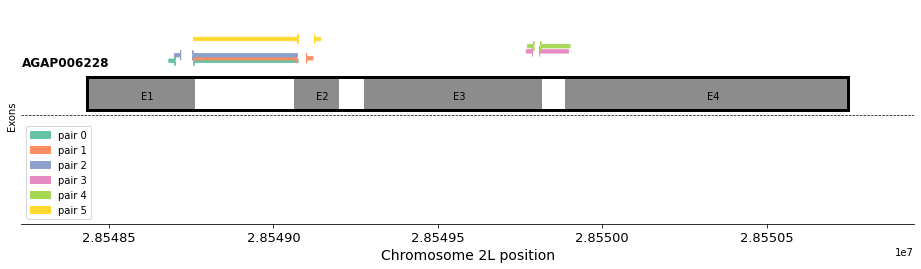

In [16]:
AgamPrimer.plot_primer_locs(
    primer_df=primer_df, 
    primer_res_dict=results_dict,
    assay_type=assay_type, 
    contig=contig, 
    seq_parameters=seq_parameters, 
    legend_loc='lower left',
    out_dir=".",
)

In [17]:
primer_df

primer_pair,0,1,2,3,4,5
parameter,,,,,,
primer_forward_sequence,GACATCGCTCTACGGGACTG,CGTTTTAAGGATCCCACGCC,CTGGGTACGTCAGCTTCCAG,CTTCGCCGGAAAGCATTGTG,GCCGGAAAGCATTGTGGATC,TTTTAAGGATCCCACGCCACC
primer_reverse_sequence,GGTGGCGTGGGATCCTTAAA,GGGTCACATTGCTCGGTACA,GGCGTGGGATCCTTAAAACG,CTTGTATTTCCTGCGGTCCG,GCCTTCTTGTATTTCCTGCGG,ACGCGCCGATCAAAATGAAA
primer_forward_tm,59.970433,59.26916,60.108615,60.454957,59.898781,60.61485
primer_reverse_tm,60.034863,60.036765,59.26916,58.993168,59.598095,59.480481
primer_forward_gc_percent,60.0,55.0,60.0,55.0,55.0,52.380952
primer_reverse_gc_percent,55.0,55.0,55.0,55.0,52.380952,45.0
primer_forward,"(249, 20)","(322, 20)","(266, 20)","(962, 20)","(966, 20)","(324, 21)"
primer_reverse,"(344, 20)","(389, 20)","(341, 20)","(1021, 20)","(1026, 21)","(413, 20)"
primer_pair_product_size,96,68,76,60,61,90


### **Checking our primers for specificity to the *Anopheles gambiae* genome**

We can use a cool new python package, [gget](https://github.com/pachterlab/gget), to rapidly search our primers against the AgamP3 genome, to ensure they will not amplify any other regions of the genome. gget rapidly queries large databases - in this case we can use the program BLAT to align primer sequences. Unfortunately as the lengths of primer sequences are so short, it is at the limit of BLATs sensitivity, and in some cases, matches are not returned. gget can also currently only query the older AgamP3 assembly. Therefore, it is also recommended run a more exhaustive search in [Primer-BLAST](https://www.ncbi.nlm.nih.gov/tools/primer-blast/).

In [18]:
blat_result_df = AgamPrimer.gget_blat_genome(
    primer_df, 
    assay_type, 
    assembly='anoGam3'
)

blat_result_df

No hit for reverse - pair 0
No hit for forward - pair 1
No hit for reverse - pair 2
No hit for reverse - pair 3
No hit for reverse - pair 4
No hit for forward - pair 5


,,genome,query_size,aligned_start,aligned_end,matches,mismatches,%_aligned,%_matched,chromosome,strand,start,end
,primer,,,,,,,,,,,,
0,forward_0,anoGam3,20,1,20,20,0,100.0,100.0,chr2L,+,28548682,28548701
1,reverse_1,anoGam3,20,1,20,20,0,100.0,100.0,chr2L,-,28549101,28549120
2,forward_2,anoGam3,20,1,20,20,0,100.0,100.0,chr2L,+,28548699,28548718
3,forward_3,anoGam3,20,1,20,20,0,100.0,100.0,chr2L,+,28549769,28549788
4,forward_4,anoGam3,20,1,20,20,0,100.0,100.0,chr2L,+,28549773,28549792
5,reverse_5,anoGam3,20,1,20,20,0,100.0,100.0,chr2L,-,28549125,28549144


### **Alternative all-in-one function**

In [19]:
#view help for function
AgamPrimer.designPrimers?

Our genome sequence for 2L is 49364325 bp long
The target sequence is 239 bases long
the target snp is 119 bp into our target sequence


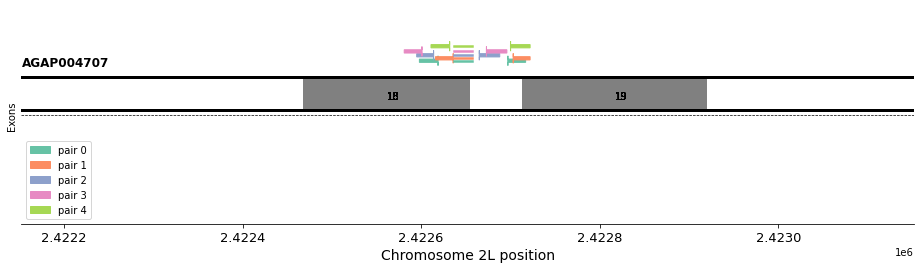

In [20]:
primer_df, blat_df = AgamPrimer.designPrimers(assay_type='gDNA primers + probe',
                                   target='2L:2422652' ,
                                   assay_name='chrom_x_region',
                                   n_primer_pairs=5,
                                   min_amplicon_size=60,
                                   max_amplicon_size=120,
                                   primer_parameters="default",
                                   sample_sets=['AG1000G-BF-A', 'AG1000G-GH', 'AG1000G-GN-A'],
                                   out_dir=".")

####**We may now have designed suitable primers. However, there are some further considerations...**


- Primers **must** be run in [**NCBI Blast**](https://blast.ncbi.nlm.nih.gov/Blast.cgi), to ensure specificity against the host organism, and specificity for the genomic location of interest. I would recommend both doing a general blast and also specifically against *An. gambiae* (TaxonID = 7165).

- If in multiplexed use with other primers or probes, primers must not interact with each other. This can be investigated on a one by one basis using the IDT tool [oligoanalyzer](https://eu.idtdna.com/calc/analyzer), though higher throughput algorithms may be required.

- If designing Locked Nucleic Acid (LNA) probes for SNP detection, you will want to play around with the placement of LNAs in the oligo sequence, which can allow short probes (~10-14 bases) to bind with high affinity and discriminate between SNPs. IDT have a tool for this which allow you to check the binding affinity between mismatches, though it requires a log in https://eu.idtdna.com/calc/analyzer/lna. 

- Many more considerations.... [IDT - How to design primers and probes for PCR and qPCR](https://eu.idtdna.com/pages/education/decoded/article/designing-pcr-primers-and-probes)   

\
  

####**Future development**

Any contributions or suggestions on how we can improve this notebook are more than welcome. Please [email](mailto:sanjay.nagi@lstmed.ac.uk) or log an [issue on github](https://github.com/sanjaynagi/primerDesignAg/issues). This notebook and source code for AnoPrimer are located here - https://github.com/sanjaynagi/AnoPrimer/    

\
####**References**

The Anopheles gambiae 1000 Genomes Consortium (2020). **Genome variation and population structure among 1142 mosquitoes of the African malaria vector species *Anopheles gambiae* and *Anopheles coluzzii***. *Genome Research*, **30**: 1533-1546. 
https://genome.cshlp.org/content/early/2020/09/25/gr.262790.120

Untergasser A, Cutcutache I, Koressaar T, Ye J, Faircloth BC, Remm M and Rozen SG (2012). **Primer3--new capabilities and interfaces**. *Nucleic Acids Research*. 40(15):e115.